# Topic Models and FOMC minutes

- NMF, LSA, LDA, PLSI matrix decomposition models
- FOMC meeting minutes

Terence Lim

In [5]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import os
import sklearn.feature_extraction, sklearn.decomposition
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from finds.unstructured import Unstructured
from finds.readers import fetch_fomc
from finds.database import MongoDB
from settings import settings
mongodb = MongoDB(**settings['mongodb'])    
fomc = Unstructured(mongodb, 'FOMC')
logdir = os.path.join(settings['images'], 'fomc')
    
# retrieve recessions dates for plotting
from finds.alfred import Alfred
alf = Alfred(api_key=settings['fred']['api_key'])
usrec = alf('USREC')
usrec.index = pd.DatetimeIndex(usrec.index.astype(str), freq='infer')
g = (usrec != usrec.shift()).cumsum()[usrec.gt(0)].to_frame()
g = g.reset_index().groupby('USREC')['date'].agg(['first','last'])
usrec = [(v[0].replace(day=1), v[1]) for k, v in g.iterrows()]
DataFrame(usrec).tail()

,0,1
30,1981-08-01,1982-11-30
31,1990-08-01,1991-03-31
32,2001-04-01,2001-11-30
33,2008-01-01,2009-06-30
34,2020-03-01,2021-02-28


## Retrieve FOMC minutes text

In [6]:
# Update FOMC Minutes
dates = fomc['minutes'].distinct('date')       # check dates stored
catalog = fetch_fomc()     # check for new dates in fomc site, and retrieve
print(f"FOMC: {len(catalog)} dates {min(catalog.keys())}-{max(catalog.keys())}")
docs = {d: fetch_fomc(url) for d, url in catalog.items() if d not in dates}
print('NEW:', ", ".join([f"{k}: {len(v)} chars " for k,v in docs.items()]))
        
# Retrieve text
docs = Series({doc['date']: doc['text'] for doc in fomc.select('minutes')},
              name='minutes').sort_index()
DataFrame(docs)

FOMC: 224 dates 19930203-20210127
NEW: 


,minutes
19930203,The Deputy Manager for Foreign Operations repo...
19930323,The Manager of the System Open Market Account ...
19930518,The Deputy Manager for Foreign Operations repo...
19930707,The Manager of the System Open Market Account ...
19930817,The Deputy Manager for Foreign Operations repo...
...,...
20200729,"Review of Monetary Policy Strategy, Tools, and..."
20200916,Developments in Financial Markets and Open Mar...
20201105,Developments in Financial Markets and Open Mar...
20201216,Developments in Financial Markets and Open Mar...


## Set stop words and Vectorize inputs

In [7]:
StopWords = [w for w in set(STOPWORDS) if "'" not in w]
StopWords += ['january', 'february', 'march', 'april', 'may', 'june',
              'july', 'august', 'september', 'october', 'november',
              'december', 'first', 'second', 'third', 'fourth', 'twelve',
              'participants', 'members', 'meeting']
ngram_range = (2, 3)
max_df, min_df, max_features = 0.5, 3, 5000 # some reasonable constraints
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words=StopWords,
    ngram_range=ngram_range,        # (2, 2) for bigrams
    max_df=max_df, min_df=min_df, max_features=max_features,
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b") #r'\b[^\d\W]+\b'
tf_vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words=StopWords,
    ngram_range=ngram_range,        # (2, 2) for bigrams
    max_df=max_df, min_df=min_df, max_features=max_features,
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")

## Define models

- set number of components = 4

In [8]:
n_components = 4
algos = {
    'LSA': (sklearn.decomposition.TruncatedSVD(n_components=n_components),
            tfidf_vectorizer),
    'LDA': (sklearn.decomposition.LatentDirichletAllocation(
        n_components=n_components,
        learning_method='online',
        learning_offset = 50.0,
        max_iter = 5,
        random_state = 42), tf_vectorizer),
    'PLSI': (sklearn.decomposition.NMF(
        n_components=n_components,
        beta_loss='kullback-leibler',
        solver='mu', 
        alpha=0.1,
        l1_ratio=0.5,
        max_iter=1000,
        random_state = 42), tf_vectorizer),
    'NMF': (sklearn.decomposition.NMF(
        n_components=n_components,
        random_state=42,
        alpha=0.1,
        l1_ratio=0.5), tfidf_vectorizer)}

## Fit models and display results

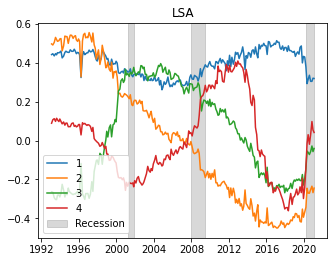

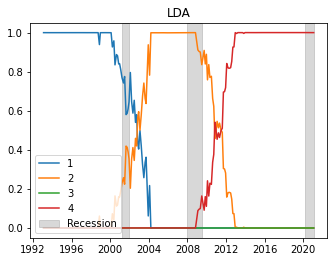

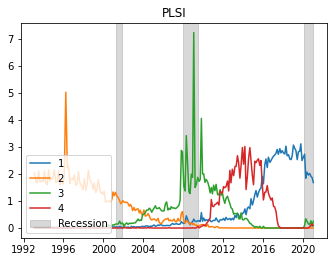

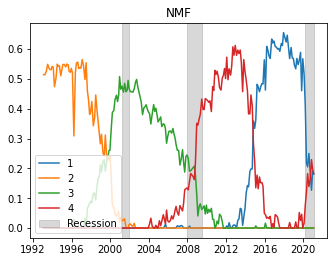

In [9]:
models = dict()
dates = dict()
for ifig, (name, (base, vectorizer)) in enumerate(algos.items()):
    vectorized = vectorizer.fit_transform(docs.to_list())
    feature_names = vectorizer.get_feature_names()
    models[name] = base.fit(vectorized)
    topics = models[name].transform(vectorized)
    
    fig, ax = plt.subplots(num=1+ifig, clear=True, figsize=(5,4))
    date = pd.DatetimeIndex(docs.index.astype(str))        
    ax.plot(date, topics)
    for a,b in usrec:
        if b >= min(date):
            ax.axvspan(a, min(b, max(date)), alpha=0.3, color='grey')
    ax.set_title(name)
    ax.legend([f"{i+1}" for i in range(n_components)] + ['Recession'],
              loc='lower left')
    plt.tight_layout(pad=2)
    for topic in range(topics.shape[1]):
        arg = DataFrame({'t': np.argmax(topics, axis=1), 'dt': docs.index})
        g = (arg!=arg.shift()).cumsum().groupby('t').agg(['first','last'])-1
        g['topic'] = arg.loc[g.iloc[:,1], 't'].values
    dates[name] = {topic: [(arg['dt'].iloc[row[0]], arg['dt'].iloc[row[1]])
                           for key, row in g.iterrows() if row[2] == topic]
                   for topic in range(topics.shape[1])}
    plt.savefig(os.path.join(logdir, name + 'topics.jpg'))

## Display top features as wordclouds

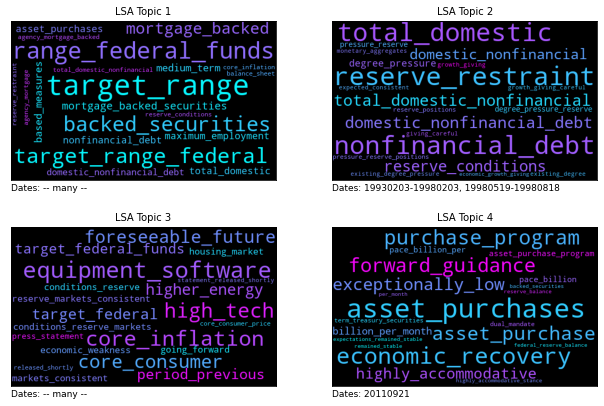

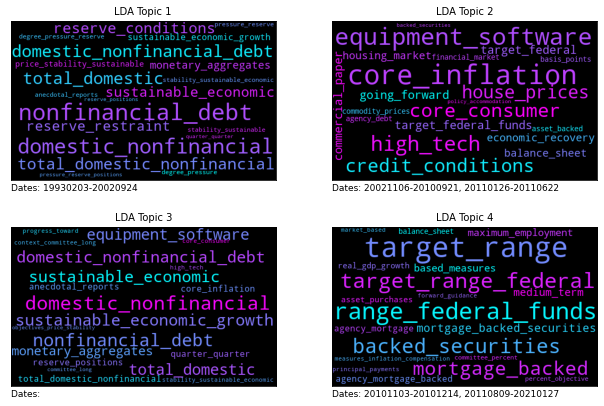

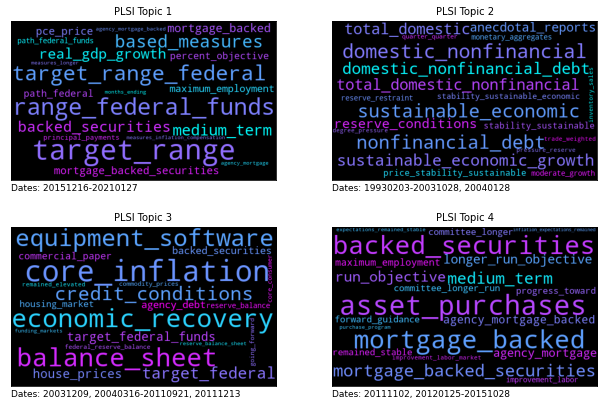

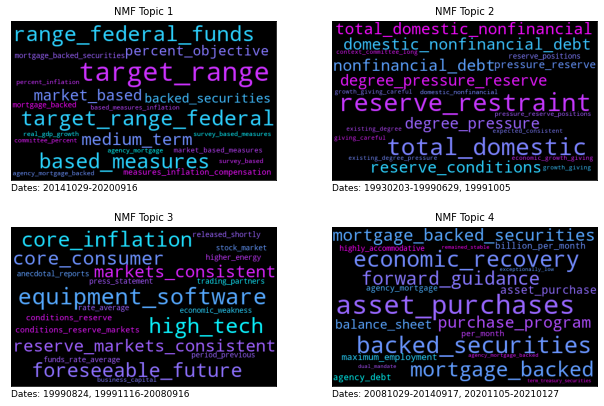

In [12]:
for ifig, (name, model) in enumerate(models.items()):
    wc = WordCloud(height=300, width=500, colormap='cool') 
    top_n = 20
    fig, axes = plt.subplots(2, 2, num=ifig+5, figsize=(10,6), clear=True)
    for topic, score in enumerate(model.components_):
        words = {feature_names[i].replace(' ','_') : score[i]
                 for i in score.argsort()[:-top_n - 1:-1]}
        #print("Topic", topic+1, dates[name])
        #print(list(words.keys()))
        ax = axes[topic//2, topic % 2]
        ax.imshow(wc.generate_from_frequencies(words))
        ax.axes.yaxis.set_visible(False)   # make axes ticks invisible
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.set_title(f"{name} Topic {topic+1}", fontsize=10)
        s = ", ".join([f"{d[0]}-{d[1]}" if d[0] != d[1] else f"{d[0]}"
                       for d in dates[name][topic]])            
        ax.set_xlabel('Dates: ' + (s if len(s)<75 else '-- many --'),
                      fontsize=9, loc='left')
        plt.tight_layout(pad=2)
    plt.savefig(os.path.join(logdir, name + 'words.jpg'))
plt.show()